In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 1. Introduction

## 1.1 Business Problem

A machine learning model will be developed to predict whether individuals are diabetic based on specified features.
Prior to model development, it is anticipated that essential steps in data analysis and feature engineering will be
undertaken.

## 1.2 Dataset Story

It is a part of a large dataset maintained by the National Institute of Diabetes and Digestive and Kidney Diseases in
the United States. The data is utilized for a diabetes study conducted on Pima Indian women aged 21 and above, residing
in Phoenix, the fifth-largest city in the state of Arizona. The target variable is indicated as `outcome`, with 1
denoting a positive diabetes test result and 0 indicating a negative result.

## 1.3 Features

- `Pregnancies` - Number of pregnancies
- `Glucose` - Plasma glucose concentration at 2 hours in an oral glucose tolerance test
- `BloodPressure` - Diastolic blood pressure (mmHg)
- `SkinThickness` - Triceps skin fold thickness (mm)
- `Insulin` - Two-hour serum insulin (μU/ml)
- `BMI` - Body mass index (kg/m²)
- `DiabetesPedigreeFunction` - Diabetes pedigree function
- `Age` - Age (years)
- `Outcome` - Presence of the disease (1) or absence (0)

# 2. Data Handling

## 2.1 Loading Data

In [2]:
# Load the dataset
diabetes = pd.read_csv('diabetes.csv')

In [3]:
# Display the first few rows
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2.2 Inspecting Data

In [4]:
# Display basic statistics about the dataset
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
# Display information about the dataset
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
# Identify columns with null values
diabetes.isnull().any()

Pregnancies                 False
Glucose                     False
BloodPressure               False
SkinThickness               False
Insulin                     False
BMI                         False
DiabetesPedigreeFunction    False
Age                         False
Outcome                     False
dtype: bool

In [7]:
# Get the number of unique values in each column
diabetes.nunique()

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

## 2.3 Data Visualization, Cleaning and Preprocessing

In [8]:
def categorize_columns(df, cat_th=10, high_card_th=20):
    """
    Categorizes columns in a DataFrame based on specified thresholds.

    Parameters:
    - df: DataFrame
    - cat_thresh: Threshold for considering a column as categorical (default is 10)
    - high_card_thresh: Threshold for considering a categorical column as having high cardinality (default is 20)

    Returns:
    - cat_cols: List of categorical columns
    - num_cols: List of numerical columns
    - high_card_cat_cols: List of categorical columns with high cardinality
    """

    # Identify categorical columns with high cardinality
    high_card_cols = [col for col in df.columns if
                      df[col].dtype in ["category", "object"] and df[col].nunique() > high_card_th]

    # Identify numerical columns that are treated as categorical
    num_but_cat_cols = [col for col in df.columns if
                        df[col].dtype in ["float64", "int64"] and df[col].nunique() < cat_th]

    # Identify categorical columns
    cat_cols = [col for col in df.columns if
                (df[col].dtype in ["category", "object", "bool"] and col not in high_card_cols) or
                (col in num_but_cat_cols)]

    # Identify numerical columns
    num_cols = [col for col in df.columns if df[col].dtype in ["float64", "int64"] and col not in cat_cols]

    # Print dataset overview
    print(f"Dataset Overview:")
    print(f" - Total Columns: {df.shape[1]}")
    print(f" - Numerical Columns: {len(num_cols)}")
    print(f" - Numerical Columns Treated as Categorical: {len(num_but_cat_cols)}")
    print(f" - Categorical Columns: {len(cat_cols)}")
    print(f" - Columns with High Cardinality: {len(high_card_cols)}")

    return cat_cols, num_cols, high_card_cols


# Categorize columns of the dataset
cat_cols, num_cols, high_card_cols = categorize_columns(diabetes)

Dataset Overview:
 - Total Columns: 9
 - Numerical Columns: 8
 - Numerical Columns Treated as Categorical: 1
 - Categorical Columns: 1
 - Columns with High Cardinality: 0


In [9]:
def handle_outliers_with_thresholds(df, col, alpha=0.25):
    """
    Handle outliers in a DataFrame column by replacing values outside the specified quantile range.

    Parameters:
    - df (pandas.DataFrame): The DataFrame containing the data.
    - col (str): The column name for which outliers will be handled.
    - alpha (float, optional): The significance level for calculating quantiles. Defaults to 0.25.

    Returns:
    Tuple[float, float]: Lower and upper bounds for the specified column after handling outliers.
    """
    # Calculate the lower and upper quantiles based on the specified alpha
    q1 = df[col].quantile(alpha)
    q3 = df[col].quantile(1 - alpha)
    iqr = q3 - q1

    # Calculate the lower and upper bounds for outlier detection
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Replace values below the lower bound with the lower bound
    df.loc[(df[col] < lower_bound), col] = lower_bound

    # Replace values above the upper bound with the upper bound
    df.loc[(df[col] > upper_bound), col] = upper_bound

    return lower_bound, upper_bound


# Outlier handling for numerical columns
for col in num_cols:
    handle_outliers_with_thresholds(diabetes, col)

Despite the dataset lacks missing observations, it is noteworthy that certain variables, such as `Glucose`, `Blood Pressure`, `Insulin`, etc., where a value of $0$ should be regarded as missing data.

Following this, these zero values should be substituted with chosen quantitative measures, such as the $mean$ for symmetrical data or the $median$ for data with outliers.

In [10]:
# Replace zero values with median
for col in num_cols:
    if col != 'Pregnancies':
        diabetes[col].replace(0, np.nan, inplace=True)
        diabetes[col].fillna(diabetes.groupby(cat_cols)[col].transform('median'), inplace=True)

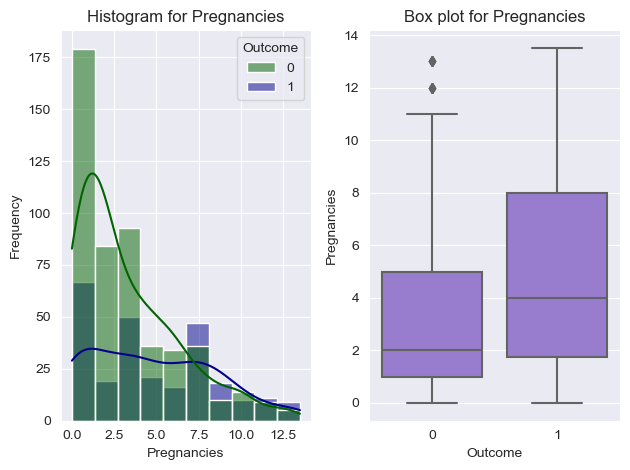

1.0     135
0.0     111
2.0     103
3.0      75
4.0      68
5.0      57
6.0      50
7.0      45
8.0      38
9.0      28
10.0     24
11.0     11
13.0     10
12.0      9
13.5      4
Name: Pregnancies, dtype: int64


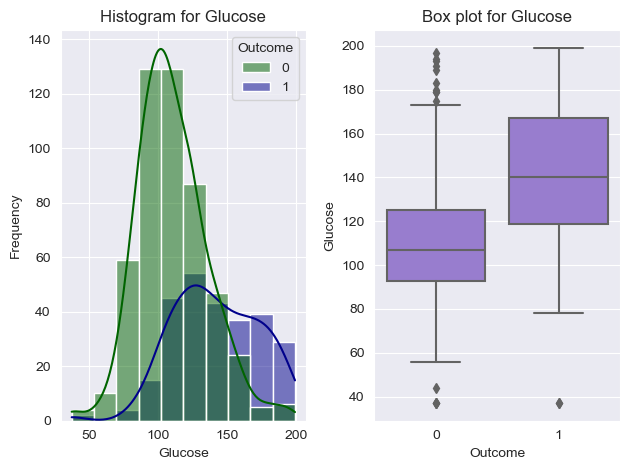

99.0     17
100.0    17
111.0    14
129.0    14
125.0    14
         ..
191.0     1
177.0     1
44.0      1
62.0      1
190.0     1
Name: Glucose, Length: 136, dtype: int64


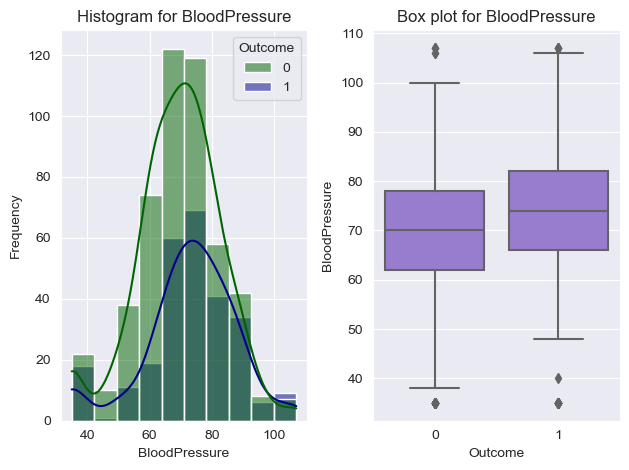

70     57
74     52
68     45
78     45
72     44
64     43
80     40
76     39
35     38
60     37
62     34
66     30
82     30
88     25
84     23
90     22
58     21
86     21
50     13
56     12
54     11
52     11
92      8
75      8
107     7
65      7
85      6
94      6
48      5
96      4
44      4
100     3
98      3
106     3
55      2
104     2
46      2
95      1
102     1
40      1
61      1
38      1
Name: BloodPressure, dtype: int64


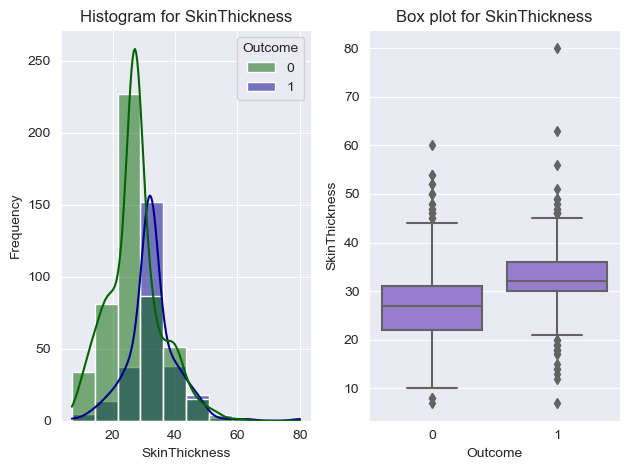

27.0    162
32.0    119
30.0     27
23.0     22
28.0     20
33.0     20
18.0     20
31.0     19
19.0     18
39.0     18
29.0     17
26.0     16
40.0     16
22.0     16
25.0     16
37.0     16
35.0     15
41.0     15
17.0     14
36.0     14
15.0     14
20.0     13
24.0     12
13.0     11
42.0     11
21.0     10
34.0      8
46.0      8
38.0      7
12.0      7
16.0      6
11.0      6
43.0      6
45.0      6
14.0      6
44.0      5
10.0      5
47.0      4
48.0      4
50.0      3
49.0      3
54.0      2
7.0       2
52.0      2
8.0       2
56.0      1
51.0      1
60.0      1
63.0      1
80.0      1
Name: SkinThickness, dtype: int64


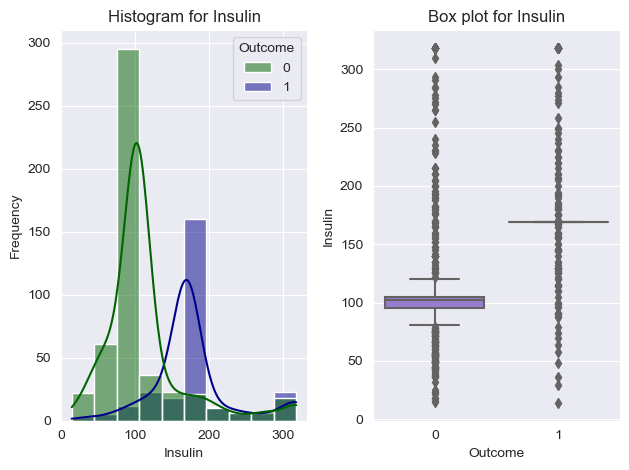

102.500    236
169.500    138
318.125     34
105.000     11
130.000      9
          ... 
51.000       1
68.000       1
29.000       1
146.000      1
112.000      1
Name: Insulin, Length: 158, dtype: int64


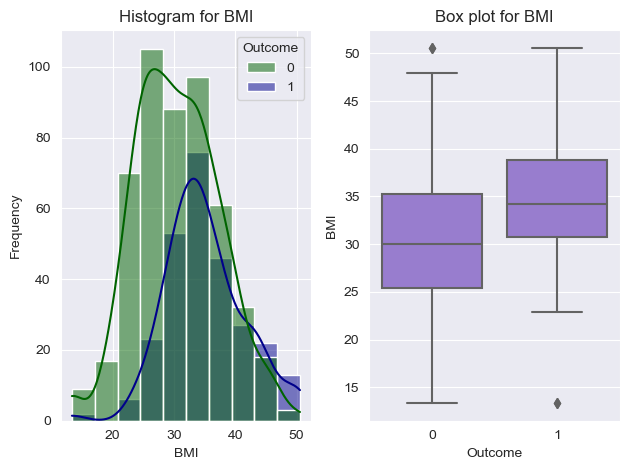

32.00    13
31.60    12
31.20    12
13.35    11
33.30    10
         ..
32.60     1
43.20     1
45.50     1
48.80     1
46.30     1
Name: BMI, Length: 242, dtype: int64


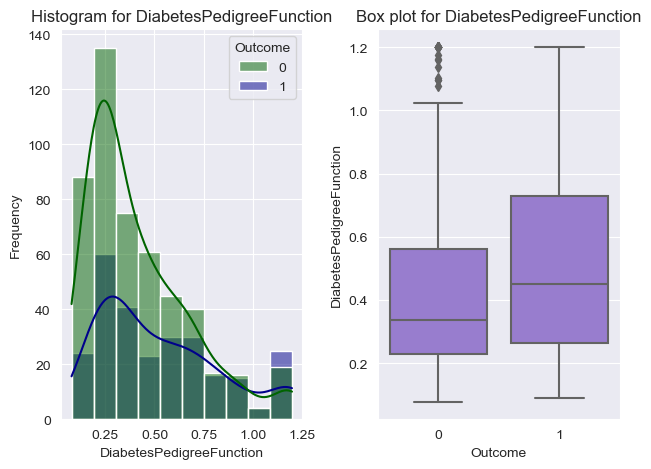

1.200    29
0.254     6
0.258     6
0.238     5
0.268     5
         ..
0.997     1
0.226     1
0.612     1
0.655     1
0.171     1
Name: DiabetesPedigreeFunction, Length: 490, dtype: int64


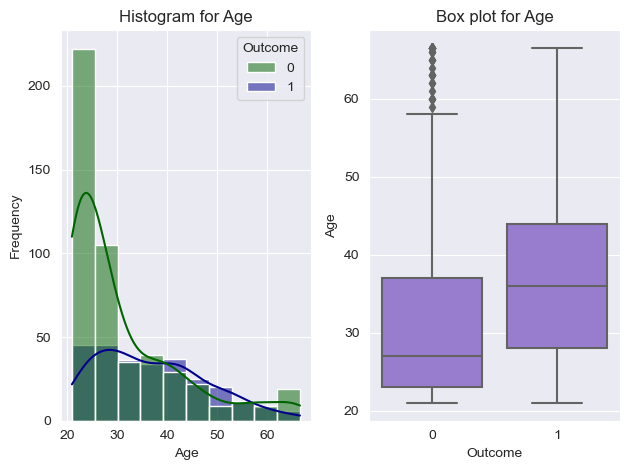

22.0    72
21.0    63
25.0    48
24.0    46
23.0    38
28.0    35
26.0    33
27.0    32
29.0    29
31.0    24
41.0    22
30.0    21
37.0    19
42.0    18
33.0    17
38.0    16
36.0    16
32.0    16
45.0    15
34.0    14
46.0    13
43.0    13
40.0    13
39.0    12
35.0    10
66.5     9
44.0     8
52.0     8
50.0     8
51.0     8
58.0     7
47.0     6
54.0     6
48.0     5
60.0     5
49.0     5
57.0     5
53.0     5
63.0     4
66.0     4
62.0     4
55.0     4
65.0     3
59.0     3
56.0     3
61.0     2
64.0     1
Name: Age, dtype: int64


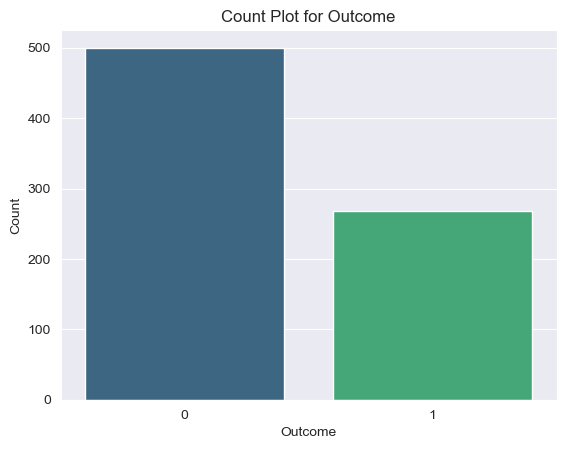

0    500
1    268
Name: Outcome, dtype: int64


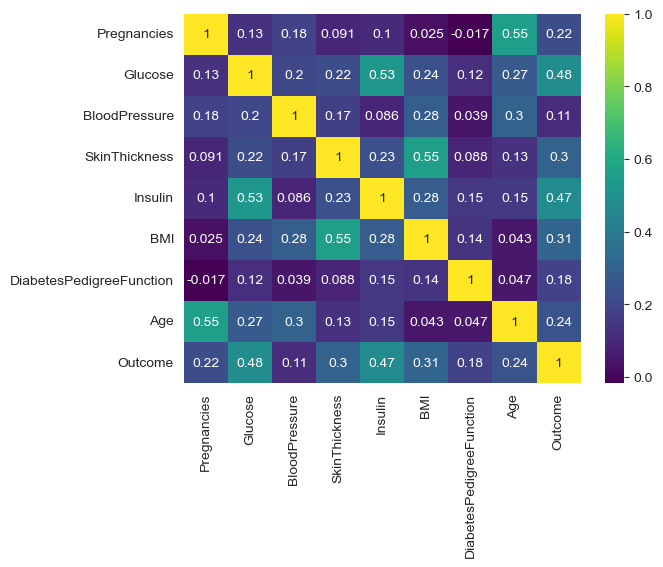

In [11]:
def summary_plots(df, num_cols=None, cat_cols=None, log_scale=False, groupby=None):
    """
    Generate summary plots for numerical and categorical columns in a DataFrame.

    Parameters:
    - df (DataFrame): The DataFrame containing the data.
    - num_cols (list, optional): List of numerical column names. Defaults to None.
    - cat_cols (list, optional): List of categorical column names. Defaults to None.
    """
    # Plot histograms and box plots for numerical columns
    if num_cols is not None:
        for col in num_cols:
            # Create subplots for histograms and boxplots
            fig, axes = plt.subplots(1, 2)

            # Histogram
            sns.histplot(data=df, x=col, bins=10, kde=True, palette=sns.color_palette(['darkgreen', 'darkblue']),
                         hue=groupby, ax=axes[0]) if groupby is not None else sns.histplot(
                data=df, x=col, bins=10, kde=True,
                color='darkgreen', ax=axes[0])
            axes[0].set_title(f'Histogram for {col}')
            axes[0].set_xlabel(col)
            axes[0].set_ylabel('Frequency')
            axes[0].set_yscale('log') if log_scale == True else _

            # Box plot
            sns.boxplot(data=df, x=groupby, y=col, color='mediumpurple',
                        ax=axes[1]) if groupby is not None else sns.boxplot(data=df, x=col, color='mediumpurple',
                                                                            ax=axes[1])
            axes[1].set_title(f'Box plot for {col}')
            axes[1].set_xlabel(groupby)
            axes[1].set_ylabel(col)
            axes[1].set_yscale('log') if log_scale == True else _

            # Adjust layout
            plt.tight_layout()

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())

    # Plot count plots for categorical columns
    if cat_cols is not None:
        for col in cat_cols:
            sns.countplot(x=col, data=df, palette='viridis')
            plt.title(f'Count Plot for {col}')
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.yscale('log') if log_scale == True else _

            # Show the plots
            plt.show()

            # Display the counts of unique values in the column
            print(df[col].value_counts())

    # Generate a heatmap
    sns.heatmap(df.corr(), annot=True, cmap='viridis')

    # Show the plot
    plt.show()


# Generate summary plots for numerical and categorical columns
summary_plots(diabetes, num_cols, cat_cols, log_scale=False, groupby='Outcome')

### 2.3.1 Feature Transformation

In [12]:
# Categorize age ranges
diabetes['AgeGroup'] = pd.cut(diabetes['Age'], bins=[diabetes['Age'].min(), 23, 26, 29, 39, float('inf')],
                              labels=['Early 20s', 'Mid 20s', 'Late 20s', '30s', 'Advanced Maternal Age'],
                              include_lowest=True)

# Display the counts of individuals in each age group
diabetes['AgeGroup'].value_counts()

Advanced Maternal Age    207
Early 20s                173
30s                      165
Mid 20s                  127
Late 20s                  96
Name: AgeGroup, dtype: int64

In [13]:
# Categorize number of pregnancies
diabetes['PregnancyGroup'] = pd.cut(diabetes['Pregnancies'],
                                    bins=[diabetes['Pregnancies'].min(), 1, 2, 3, 5, float('inf')],
                                    labels=['None', '1', '2', '3-4', '5+'], include_lowest=True)

# Display the counts of individuals in each pregnancy group
diabetes['PregnancyGroup'].value_counts()

None    246
5+      219
3-4     125
1       103
2        75
Name: PregnancyGroup, dtype: int64

In [14]:
# Categorize BMI
diabetes['BMIGroup'] = pd.cut(diabetes['BMI'], bins=[diabetes['BMI'].min(), 18.5, 24.9, 29.9, float('inf')],
                              labels=['Underweight', 'Normal', 'Overweight', 'Obese'], include_lowest=True)

# Display the counts of individuals in each BMI group
diabetes.BMIGroup.value_counts()

Obese          472
Overweight     179
Normal         102
Underweight     15
Name: BMIGroup, dtype: int64

### 2.3.2 Encoding

Since the categorical variables generated through transformations exhibit an inherent order (with a clear relation of magnitude), the most suitable encoding technique to use is **ordinal encoding**.


In [15]:
# Categorize columns of the dataset
cat_cols, num_cols, high_card_cols = categorize_columns(diabetes)

# Remove target column
cat_cols.remove('Outcome')

# Perform ordinal encoding on categorical columns
for col in cat_cols:
    encoder = OrdinalEncoder(categories=[diabetes[col].unique().sort_values().tolist()])
    diabetes[col] = encoder.fit_transform(diabetes[[col]])

Dataset Overview:
 - Total Columns: 12
 - Numerical Columns: 8
 - Numerical Columns Treated as Categorical: 1
 - Categorical Columns: 4
 - Columns with High Cardinality: 0


### 2.3.3 Scaling

In [16]:
# Perform standard scaling on numerical columns
scaler = StandardScaler()
diabetes[num_cols] = scaler.fit_transform(diabetes[num_cols])

# 3. Modeling

In [17]:
# Extract the target variable and the features
y = diabetes['Outcome']
X = diabetes.drop('Outcome', axis=1)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1923)

# Initialize the model
rf = RandomForestClassifier(random_state=1923, n_estimators=200, min_samples_split=10)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions
y_pred = rf.predict(X_test)

# 4. Results

In [18]:
# Print evaluation metrics
print("\nMetrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.4f}")


Metrics:
Accuracy: 0.8831
Precision: 0.8608
Recall: 0.8095
F1 Score: 0.8344
ROC-AUC: 0.8673


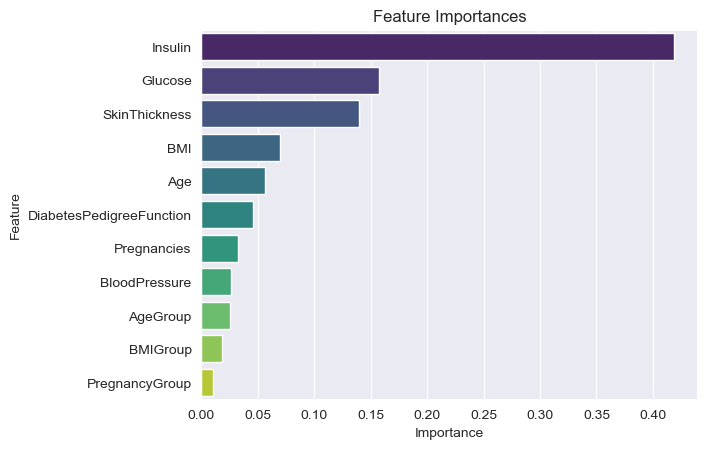

In [19]:
# Create a DataFrame to display feature importances
importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
importance = importance.sort_values(by='Importance', ascending=False)

# Visualize feature importances
sns.barplot(x='Importance', y='Feature', data=importance, palette='viridis')
plt.title('Feature Importances')
plt.show()